### Neural Computation Exercise 4: Back Propagation
In this exercise, we will solve a binary classification problem by a 2-layer neural network. The data is not linearly separable and therefore the perceptron algorithm introduced in the last week will not work. We will train the neural network by gradient descent. To this aim, we need to compute gradients by the backpropagation algorithm.

After finishing this exercise, you will learn the following
* forward propagation
* backward propagation

First, we will import necessary libraries. Note we can import the `sigmoid` function from the `scipy` module.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid
import math


## Data

We will define a function `make_dataset(num_points)` to generate a two-dimensional dataset. We use `np.random.seed(0)` to initialize the random number generator. Then, different runs of the code will produce the same results.

The function `make_dataset(num_points)` generates `num_points` examples. The **first half** are positive examples and the **second half** are negative examples. Note that the positive examples are of smaller distance to the zero point, while the negative examples are of larger distance to the zero point. It is clear that this dataset is not linearly separable, i.e., we cannot find a linear function to separate positive examples from negative examples.

In [4]:
np.random.seed(0)

def make_dataset(num_points):
    radius = 5
    data = []
    labels = []
    # Generate positive examples (labeled 1).
    for i in range(num_points // 2):
        # the radius of positive examples
        r = np.random.uniform(0, radius*0.5)
        angle = np.random.uniform(0, 2*math.pi)
        x = r * math.sin(angle)
        y = r * math.cos(angle)
        data.append([x, y])
        labels.append(1)
        
    # Generate negative examples (labeled 0).
    for i in range(num_points // 2):
        # the radius of negative examples
        r = np.random.uniform(radius*0.7, radius)
        angle = np.random.uniform(0, 2*math.pi)
        x = r * math.sin(angle)
        y = r * math.cos(angle)
        data.append([x, y])
        labels.append(0)
        
    data = np.asarray(data)
    labels = np.asarray(labels)
    return data, labels

### Visualization of Data

We first apply `make_dataset` to generate a dataset of 200 examples. We visualise the dataset using a `scatter` plot using the scatter function in the `matplotlib.pylot` module.

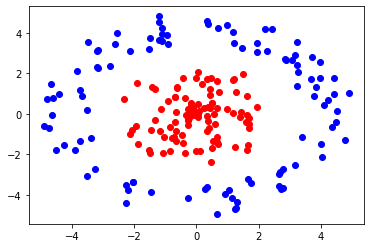

In [5]:
num_data = 200
data, labels = make_dataset(num_data)

# Note: red indicates a label of 1, blue indicates a label of 0
plt.scatter(data[:num_data//2, 0], data[:num_data//2, 1], color='red') 
plt.scatter(data[num_data//2:, 0], data[num_data//2:, 1], color='blue') 

## Neural network definition

We will try to classify this data by training a neural network. As a reminder, our goal is to take as input a two dimensional vector $\mathbf{x} = [x_1, x_2]^\top$ and output a real number from which we can predict the output label. We consider the following structure. The neural network has three layers: the first layer has $2$ nodes, the second layer has $3$ nodes and the last layer has $1$ node. In this case, the parameters we want to learn are **weight matrices**: $W^2\in \mathbb{R}^{3\times 2}, W^3\in\mathbb{R}^{1\times 3}$ and **bias vectors**: $b^2\in\mathbb{R}^3$ and $b^3\in\mathbb{R}$. Here we initialize the weights using the [**randn**](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html) function, and the bias as the zero vectors.

In [7]:
# First, initialize our neural network parameters.
params = {}
params['W2'] = np.random.randn(3, 2)
params['b2'] = np.zeros(3)
params['W3'] = np.random.randn(3)
params['b3'] = 0

### Forward Propagation

We now implement **forward propagation** to compute the output of the network. According to the `forward propagation` algorithm, we know
$$\mathbf{z}^2 = \mathbf{W}^2x+\mathbf{b}^2$$
$$\mathbf{a}^2 = \sigma(\mathbf{z}^2)$$
$$\mathbf{z}^3 = \mathbf{W}^3\mathbf{a}^2+\mathbf{b}^3$$
$$\mathbf{a}^3 = \sigma(\mathbf{z}^3)$$

That is, $\mathbf{z}$ are linear functions of inputs and $\mathbf{a}$ are activations of $\mathbf{z}$.

In [13]:
# To do: complete the implementation the forward propagation by computing z2,a2,z3,a3. 
# This function returns the predicted output of the network, i.e., a3 in the above equation
def forward(x, params):    
    '''
    Input:
        x: the feature vector of an example
        params: a dictionary containing both weight matrices and bias vectors of a neural network
    Output:
        return the function valued computed by the neural network
    '''
    z2 = np.dot(params['W2'], x) + params['b2']
    a2 = sigmoid(z2)
    z3 = np.dot(params['W3'], a2) + params['b3']
    a3 = sigmoid(z3)
    return a3

### Visualize the network's predictions

Let's visualize the predictions of our untrained network. As we can see, the network does not succeed at classifying the points without training

/tmp/ipykernel_13932/3908868581.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X1, X2, Y, cmap=plt.cm.get_cmap('YlGn'))


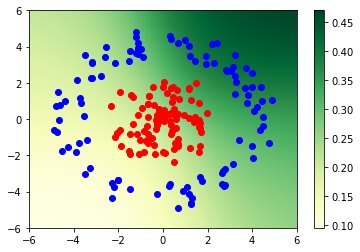

In [14]:
num_points = 200

# we first traverse two features in the region (-6,6)
x1s = np.linspace(-6.0, 6.0, num_points)
x2s = np.linspace(-6.0, 6.0, num_points)

# we now use forward propagation to compute the matrix Y
# Y[i, j] should be the output of the network on the example (x1s[i], x2s[j]) 
# To do: insert your code here the compute Y
Y = np.zeros([num_points, num_points])
for i in range(num_points):
    for j in range(num_points):
        x = np.array([x1s[i], x2s[j]])
        Y[i, j] = forward(x, params)
# we now visualize the data
X1, X2 = np.meshgrid(x1s, x2s)
plt.pcolormesh(X1, X2, Y, cmap=plt.cm.get_cmap('YlGn'))
plt.colorbar()
plt.scatter(data[:num_data//2, 0], data[:num_data//2, 1], color='red') 
plt.scatter(data[num_data//2:, 0], data[num_data//2:, 1], color='blue') 

### Derivative of Sigmoid function

Before implementing the backward propagation, we need to know the derivative of the sigmoid function

$$\sigma(x)=1/(1+\exp(-x))$$
In the following, you are requested to complete the code on computing the gradient of the sigmoid function

In [20]:
# To do: insert your code here to compute the gradient of the sigmod function

def sigmoid_derivative(x):
    """
    Compute the gradient (slope/derivative) of the sigmoid function with
    respect to its input x.

    Args:
     x: scalar or numpy array

    Returns:
     gradient: gradient of the sigmoid function with respect to x
    """
    sigma_x = sigmoid(x)
    return sigma_x * (1 - sigma_x)

### Implement back propagation

We now implement the back propagation to compute the gradients of the loss function on the parameters $W^2, W^3, b^2, b^3$. We consider the square loss
$$
C(a^3,y)=\frac{1}{2}(a^3-y)^2,
$$
where $a^3$ is the output of the network with the input $\mathbf{x}$. According to the back propagation algorithm, we need to compute the back-propagated gradients
$$
\delta^3:=\frac{\partial C}{\partial \mathbf{z}^3}\quad\text{and}\quad\delta^2=\frac{\partial C}{\partial \mathbf{z}^2}.
$$
In particular, the `back-propagated gradients` for the **output layer** can be derived by (note that $\delta^3\in\mathbb{R}$ since the last layer only has 1 node)
$$
\delta^3=\sigma'(z^3)(a^3-y).
$$
Then, the recursive relationship allows us to compute the `back-propagated gradients` for the **hidden layer** as follows
$$
\delta^2=(\mathbf{W}^3)^\top\delta^3\odot \sigma'(\mathbf{z}^2).
$$
This finishes the computation of the `back-propagated gradients`. We now can use these `back-propagated gradients` to compute the gradients of the loss $C$ on $\mathbf{W}^2, \mathbf{W}^3, \mathbf{b}^2, \mathbf{b}^3$. According to our discussion in the lecture, we know
$$
\frac{\partial C}{\partial \mathbf{W}^{\ell}}=\delta^\ell(\mathbf{a}^{\ell-1})^\top,\qquad\ell=2,3.
$$
$$
\frac{\partial C}{\partial \mathbf{b}^\ell}=\delta^\ell\qquad\ell=2,3.
$$

In [23]:
def backprop(x, y, params):
    """
    Compute the gradient of the loss with parameters W2, W3, b2 and b3

    Args:
     x: the input feature, a d dimensional vector
     y: the output, a real number
     params: the parameters W2, W3, b2 and b3

    Returns:
     grads: the gradient of the loss with parameters W2, W3, b2 and b3
     loss: the loss incurred by using the neural network on the example
    """
    # Perform forwards computation.
    W2 = params['W2']
    W3 = params['W3']
    
    # To Do: insert your code to compute z2, a2, z3, a3 and loss
    z2 = np.dot(W2, x) + params['b2']
    a2 = sigmoid(z2)
    z3 = np.dot(W3, a2) + params['b3']
    a3 = sigmoid(z3)
    loss = 0.5 * (a3 - y) ** 2
    
    # Perform backwards computation.
    # To Do: insert your code to compute z3_bar, z2_bar, W3_bar, W2_bar, b3_bar, b2_bar
    '''
    z3_bar is the gradient of C w.r.t. z3
    z2_bar is the gradient of C w.r.t. z2
    w3_bar is the gradient of C w.r.t. w3
    w2_bar is the gradient of C w.r.t. w2  
    b3_bar is the gradient of C w.r.t. b3
    b2_bar is the gradient of C w.r.t. b2
    Hint: you may need the np.outer function to realize the multiplication v1 * v2.T for two vectors v1, v2
    '''
    z3_bar = sigmoid_derivative(z3) * (a3 - y)
    z2_bar = np.dot(W3.T, z3_bar) * sigmoid_derivative(z2)
    W3_bar = z3_bar * a2
    W2_bar = np.outer(z2_bar, x)
    b3_bar = z3_bar
    b2_bar = z2_bar
    
    # Wrap our gradients in a dictionary.
    grads = {}
    grads['W3'] = W3_bar
    grads['W2'] = W2_bar
    grads['b3'] = b3_bar
    grads['b2'] = b2_bar
    
    return grads, loss


### Train the network

We can train our network parameters using gradient descent once we have computed derivatives using the backpropagation algorithm. Recall that the gradient descent update rule for a given parameter $p$ and a learning rate $\eta$ is:

$$p \gets p - \eta * \frac{\partial C}{\partial p}.$$
Note $C$ should be an average of the error on all training examples for applying gradient descent. Our backpropagation algorithm only computes the gradient based on a **single** example.

In [24]:
np.random.seed(0)

# First, initialize our neural network parameters.
params = {}
params['W2'] = np.random.randn(3, 2)
params['b2'] = np.zeros(3)
params['W3'] = np.random.randn(3)
params['b3'] = 0

num_steps = 1000
eta = 5
for step in range(num_steps):  
    grads = {}
    grads['W2'] = np.zeros((3, 2))
    grads['b2'] = np.zeros(3)
    grads['W3'] = np.zeros(3)
    grads['b3'] = 0
    loss = 0
    for i in range(num_data): 
        """
        tgrads is the gradient of the network w.r.t. the parameter in the i-th training example
        tloss is the loss in the i-th training example
        we first sum the gradients on all training examples, which is then divided by num_data to get an average
        """
        tgrads, tloss = backprop(data[i, :], labels[i], params)
        loss += tloss        
        for k in grads:
            grads[k] += tgrads[k]
    # we now compute an average of loss
    loss /= num_data  
    for k in params:
        grads[k] /= num_data
        # To do: insert your code to do gradient descent
        params[k] -= eta * grads[k]        
        

    # Print loss every 25 iterations
    if step % 25 == 0:
        print("Step {:3d} | Loss {:3.2f}".format(step, loss))

Step   0 | Loss 0.13
Step  25 | Loss 0.12
Step  50 | Loss 0.11
Step  75 | Loss 0.08
Step 100 | Loss 0.06
Step 125 | Loss 0.04
Step 150 | Loss 0.03
Step 175 | Loss 0.02
Step 200 | Loss 0.02
Step 225 | Loss 0.02
Step 250 | Loss 0.02
Step 275 | Loss 0.01
Step 300 | Loss 0.01
Step 325 | Loss 0.01
Step 350 | Loss 0.01
Step 375 | Loss 0.01
Step 400 | Loss 0.01
Step 425 | Loss 0.01
Step 450 | Loss 0.01
Step 475 | Loss 0.01
Step 500 | Loss 0.01
Step 525 | Loss 0.01
Step 550 | Loss 0.01
Step 575 | Loss 0.01
Step 600 | Loss 0.01
Step 625 | Loss 0.01
Step 650 | Loss 0.01
Step 675 | Loss 0.01
Step 700 | Loss 0.01
Step 725 | Loss 0.01
Step 750 | Loss 0.01
Step 775 | Loss 0.01
Step 800 | Loss 0.01
Step 825 | Loss 0.01
Step 850 | Loss 0.01
Step 875 | Loss 0.01
Step 900 | Loss 0.01
Step 925 | Loss 0.01
Step 950 | Loss 0.01
Step 975 | Loss 0.01


### Visualizing the predictions

We now visualize the results of the network trained by gradient descent. We expect this trained network would have much better prediction performance. Note the network outputs a value in $[0,1]$. Therefore, a natural choice for prediction is to predict a **positive example** if the output is larger than $0.5$, and **a negative example** otherwise.

/tmp/ipykernel_13932/2512611174.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X1, X2, Y, cmap=plt.cm.get_cmap('YlGn'))


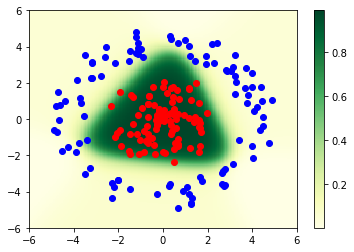

In [25]:
num_points = 200
x1s = np.linspace(-6.0, 6.0, num_points)
x2s = np.linspace(-6.0, 6.0, num_points)
Y = np.zeros([num_points, num_points])

# Y[i, j] should be the output of the network on the example (x1s[i], x2s[j]) 
# To do: insert your code here the compute Y
for i in range(num_points):
    for j in range(num_points):
        x = np.array([x1s[i], x2s[j]])
        Y[i, j] = forward(x, params)
X1, X2 = np.meshgrid(x1s, x2s)
plt.pcolormesh(X1, X2, Y, cmap=plt.cm.get_cmap('YlGn'))
plt.colorbar()
plt.scatter(data[:num_data//2, 0], data[:num_data//2, 1], color='red') 
plt.scatter(data[num_data//2:, 0], data[num_data//2:, 1], color='blue') 

As illustrated above, the output on most positive examples have values larger than 0.5, and the output on most negative examples have values smaller than 0.5. This means that the trained network indeed does a good performance on classification in this problem!

We can compute its accuracy on the training dataset. To this aim, we go through all training examples and compute the predicted label. Since the sigmoid function outputs the number between 0 and 1, we can use 0.5 as the threshold. That is, we predict it as a positiv example if the output of the network is larger than 0.5, and a negative example otherwise. As you can see, we achieve a very high accuracy. This demonstrates the efficiency of the network in solving the binary classification problem.

In [26]:
from sklearn.metrics import accuracy_score
predicted_y = np.zeros(num_data)
for i in range(num_data): 
    predicted_y[i] = forward(data[i, :], params)
    if predicted_y[i]>0.5:
        predicted_y[i] = 1
    else:
        predicted_y[i] = 0
acc_tr = accuracy_score(predicted_y, labels)
print(acc_tr)

0.995


### Minibatch Gradient Descent

In the above implementation, we use gradient descent to train the neural network. We now use minibatch gradient descent to train the neural network. The basic idea is to use a subsample to compute an approximate gradient. 

The optimization problem in ML often has a **sum** structure in the sense
$$
C(\mathbf{w})=\frac{1}{n}\sum_{i=1}^nC_i(\mathbf{w}),
$$
where $C_i(\mathbf{w})$ is the loss of the model $\mathbf{w}$ on the $i$-th example. In our problem, $C_i$ takes the form $C_i(\mathbf{w})=\frac{1}{2}(nn(x^{(i)})-y^{(i)})^2$, where $nn(x^{(i)})$ is the output of the neural network with the input $x^{(i)}$.

Gradient descent requires to go through all training examples to compute a single gradient, which may be time consuming if the sample size is large. Minibatch gradient descent improves the efficiency by using a subset of training examples to build an **approximate** gradient. At each iteration, it first randomly draws a set $I\subset\{1,2,\ldots,n\}$ of size $s$, where we often call $s$ the minibatch size. Then it builds an approximate gradient by
$$
\nabla_I(\mathbf{w}^{(t)})=\frac{1}{s}\sum_{i\in I}\nabla C_i(\mathbf{w}^{(t)})
$$
Now, it updates the model by
$$
\mathbf{w}^{(t+1)}=\mathbf{w}^{(t)}-\eta_t\nabla_I(\mathbf{w}^{(t)}).
$$ 
It is recommended to use $s\in[20,100]$. Depending on different $s$, minibatch gradient descent recovers several algorithms
\begin{align*}
  s<n \;&\Rightarrow\;\text{Minibatch gradient descent}\\
  s=1 \;&\Rightarrow\;\text{Stochastic gradient descent} \\
  s=n \;&\Rightarrow\;\text{Batch gradient descent}
\end{align*}
In the following, we request you to finish the following implementation of the `minibatch gradient descent` on the linear regression problem. To search a subset of $\{1,2,\ldots,n\}$, we recommend you to use the function `random.sample`. The synatx is `random.sample(sequence, k)`, which returns $k$ length new list of elements chosen from the `sequence`. More details can be found  [here](https://www.geeksforgeeks.org/python-random-sample-function/)

In [29]:
import random
np.random.seed(0)

# First, initialize our neural network parameters.
params = {}
params['W2'] = np.random.randn(3, 2)
params['b2'] = np.zeros(3)
params['W3'] = np.random.randn(3)
params['b3'] = 0

num_steps = 500
eta = 5

batch_size = 25
tset = list(range(num_data))
for step in range(num_steps):  
    grads = {}
    grads['W2'] = np.zeros((3, 2))
    grads['b2'] = np.zeros(3)
    grads['W3'] = np.zeros(3)
    grads['b3'] = 0
    loss = 0
    # To do, use the random.sample function to select a subset of examples to compute the gradient
    idx = random.sample(tset, batch_size)
    for i in idx: 
        """
        tgrads is the gradient of the network w.r.t. the parameter in the i-th training example
        tloss is the loss in the i-th training example
        we first sum the gradients on all training examples, which is then divided by num_data to get an average
        """
        tgrads, tloss = backprop(data[i, :], labels[i], params)
        loss += tloss
        for k in grads:
            grads[k] += tgrads[k]
    # we now compute an average of loss
    loss /= batch_size  
    for k in params:
        # To do: insert your code to do gradient descent
        grads[k] /= batch_size
        params[k] -= eta * grads[k]

Similarly, we can see the performance of the trained network with the minibatch gradient descent. It still has a good performance!

In [30]:
num_points = 200
predicted_y = np.zeros(num_data)
for i in range(num_data): 
    predicted_y[i] = forward(data[i, :], params)
    if predicted_y[i]>0.5:
        predicted_y[i] = 1
    else:
        predicted_y[i] = 0
acc_tr = accuracy_score(predicted_y, labels)
print(acc_tr)

0.99
